# **CUSTOMER CHURN PREDICTION**

The aim of this project is to develop a predictive model for customer churn in a subscription-based service or business. Customer churn, or customer attrition, refers to the rate at which customers stop using a service. By analyzing historical customer data and utilizing machine learning algorithms such as Logistic Regression, Random Forests, or Gradient Boosting,aim to predict which customers are likely to churn in the future.

In [1]:
!pip install seaborn scikit-learn

In [2]:
!pip install xgboost

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings("ignore")

In [6]:
churn_df = pd.read_csv('/content/Churn_Modelling.csv')

In [7]:
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
churn_df.columns = churn_df.columns.str.strip().str.lower()

In [9]:
churn_df.drop(['rownumber', 'customerid', 'surname','geography','gender'],axis = 1, inplace=True)

In [10]:
churn_df.isnull().sum()

creditscore        0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [11]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   age              10000 non-null  int64  
 2   tenure           10000 non-null  int64  
 3   balance          10000 non-null  float64
 4   numofproducts    10000 non-null  int64  
 5   hascrcard        10000 non-null  int64  
 6   isactivemember   10000 non-null  int64  
 7   estimatedsalary  10000 non-null  float64
 8   exited           10000 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 703.2 KB


In [12]:
churn_df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


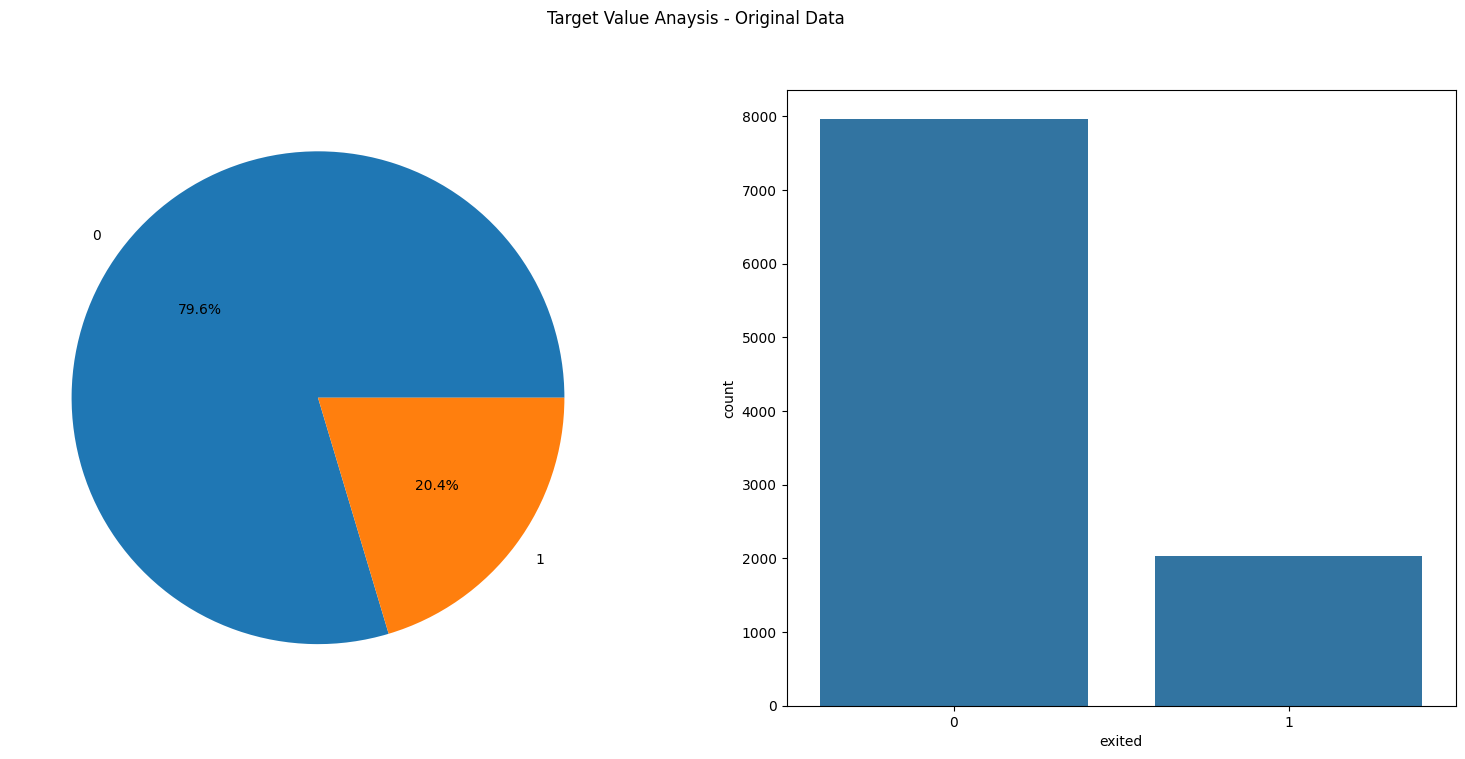

In [13]:
f, ax = plt.subplots(1, 2, figsize = (19,8))
churn_df['exited'].value_counts().plot.pie(autopct = '%1.1f%%', ax = ax[0], shadow=False)
# ax[0].set_title('Pie-Plot')
ax[0].set_ylabel('')
sns.countplot(x = 'exited', data = churn_df, ax = ax[1])
# ax[1].set_title('Count-Plot')
plt.suptitle('Target Value Anaysis - Original Data')
plt.show()

In [14]:
# Unique value counts for each column
# Threshold to distinguish continuous and categorical
threshold = 12

continuous_vars = churn_df.nunique()[churn_df.nunique() > threshold].index.tolist()
categorical_vars = churn_df.nunique()[churn_df.nunique() <= threshold].index.tolist()

# Removing the 'exited' from categorical since it's our target variable
if 'exited' in categorical_vars:
    categorical_vars.remove('exited')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"Continousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['tenure', 'numofproducts', 'hascrcard', 'isactivemember']
Continousl/Numerical Variables: ['creditscore', 'age', 'balance', 'estimatedsalary']


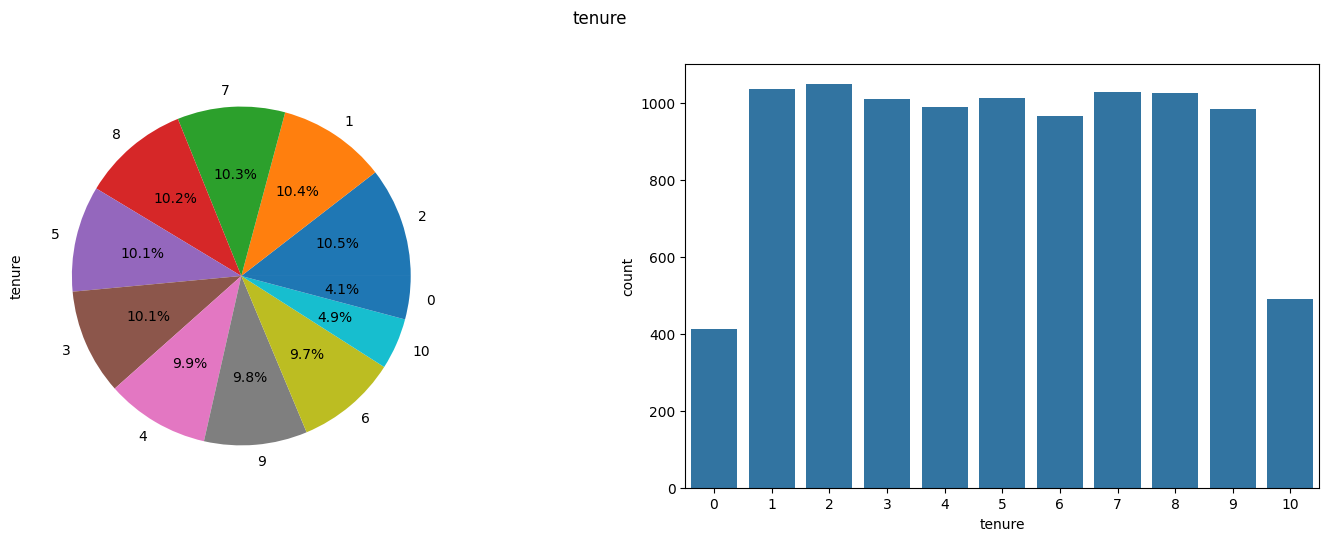

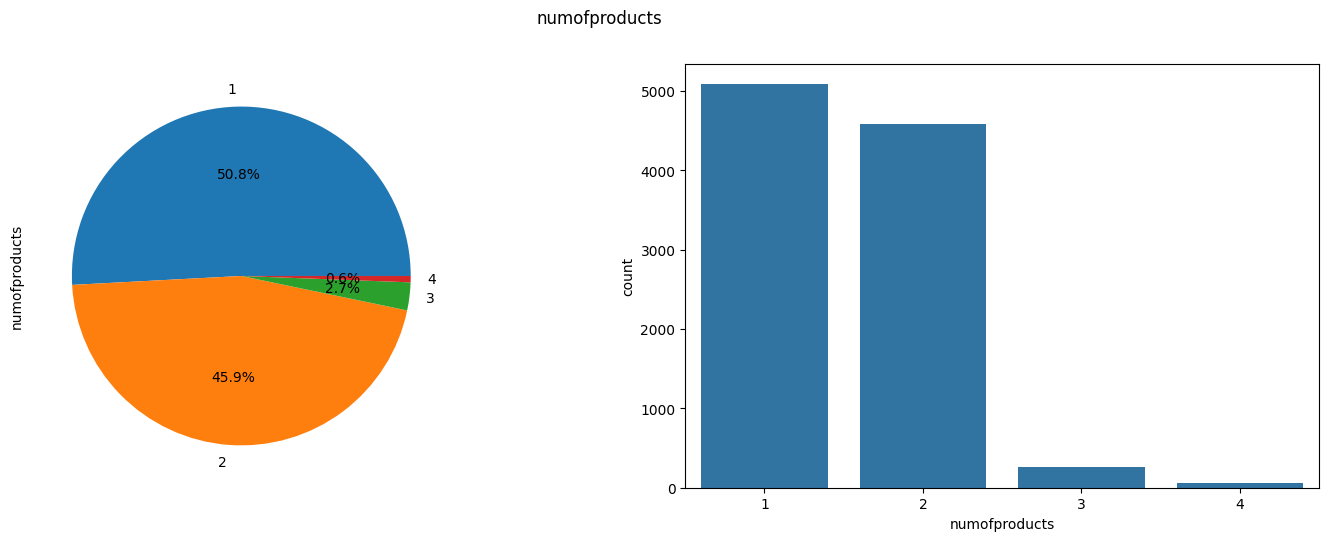

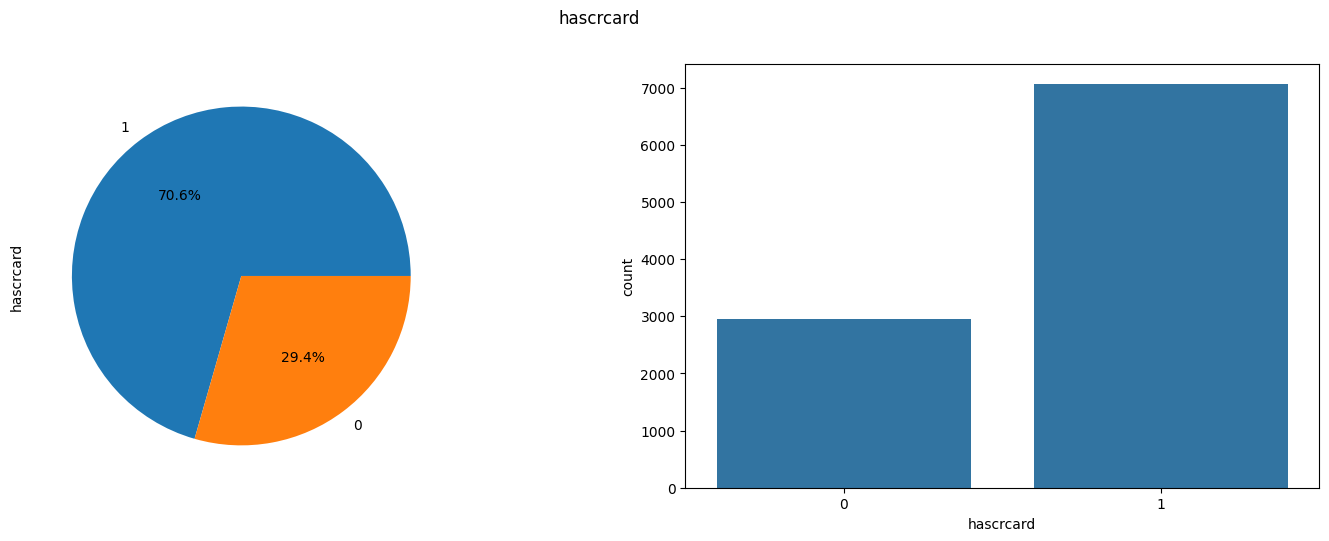

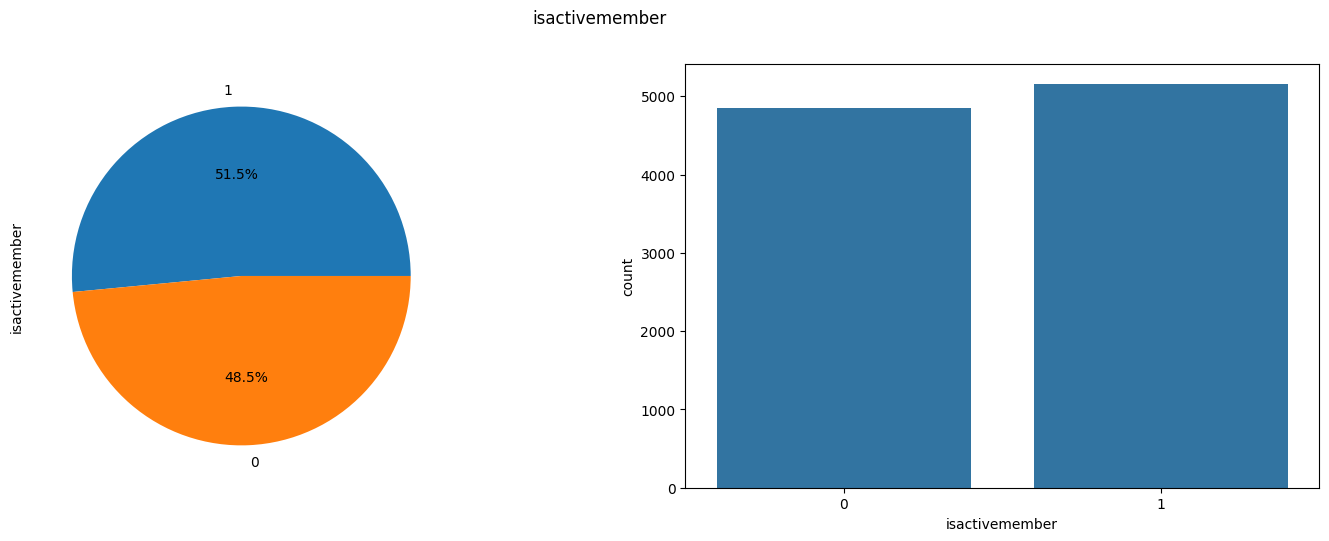

In [15]:
for column in categorical_vars:
    f, ax = plt.subplots(1, 2, figsize = (18, 5.5))
    churn_df[column].value_counts().plot.pie(autopct = '%1.1f%%', ax = ax[0], shadow = False)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x = column, data = churn_df, ax=ax[1])
    plt.suptitle(f'{column}')
    plt.show()

## **Correlation Analysis:**
Correlation is the statistical analysis of the relationship or dependency between two variables. Correlation allows us to study both the strength and direction of the relationship between two sets of variables.

There are mainly 3 types of Correlations:

* Positive Correlation: Two variables are said to be positively correlated when their values move in the same direction.
* Neutral Correlation: No relationship in the change of variables X and Y. In this case, the values are completely random and do not show any sign of correlation.
* Negative Correlation: Finally, variables X and Y will be negatively correlated when their values change in opposite directions.

<Axes: xlabel='None', ylabel='exited'>

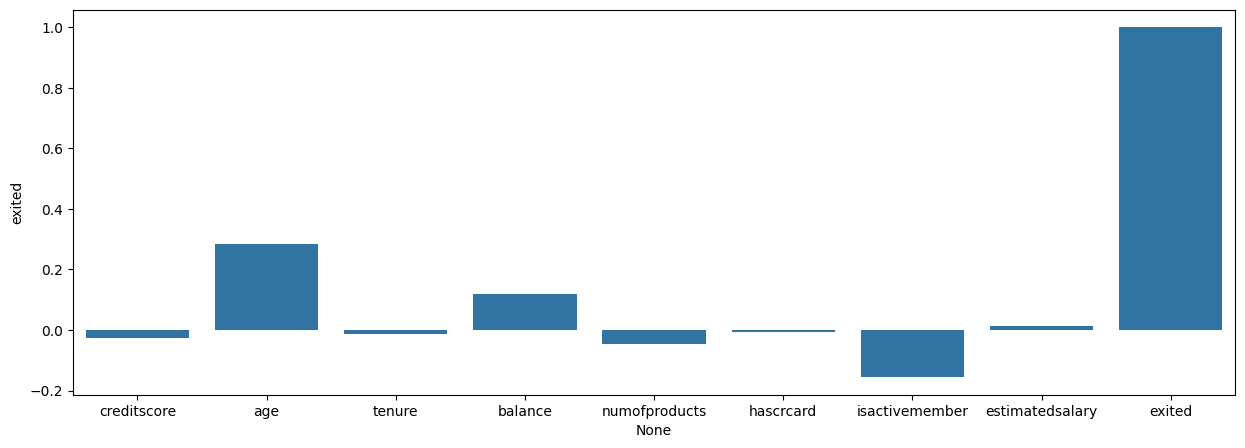

In [16]:
df_corr_exit = churn_df.corr()['exited'].to_frame()
plt.figure(figsize = (15,5))
sns.barplot(data = df_corr_exit, x = df_corr_exit.index, y = 'exited')

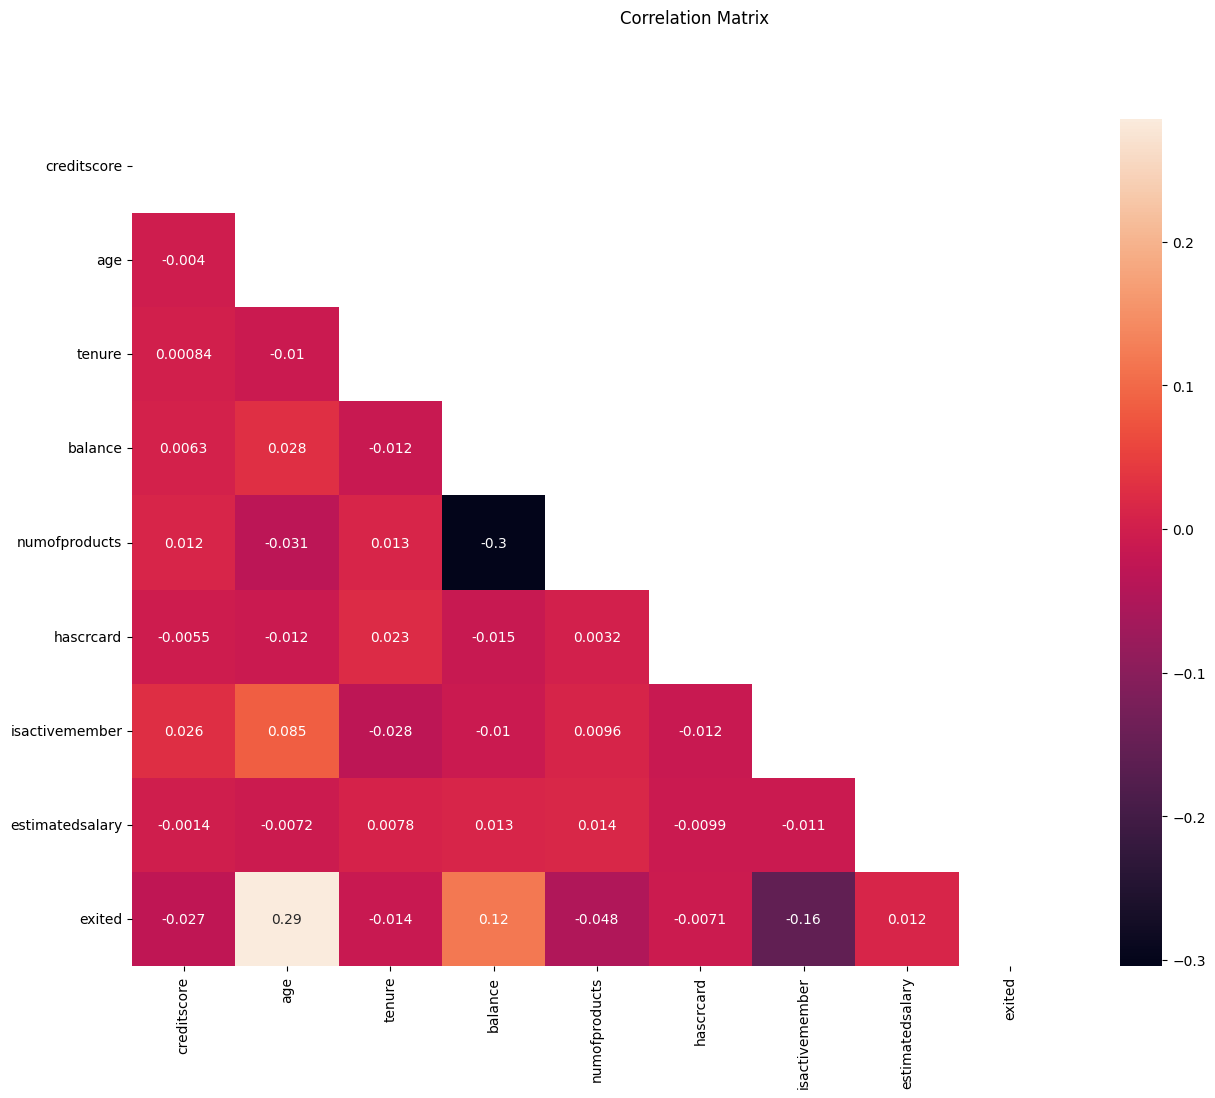

In [17]:
corr_matrix=churn_df.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (15,11))
sns.heatmap(corr_matrix, mask = mask, annot = True)
plt.suptitle('Correlation Matrix')
plt.show()

In [18]:
x = churn_df.drop(['exited'], axis = 1)
y = churn_df['exited']

In [19]:
x_encoded = pd.get_dummies(x, columns=['isactivemember', 'hascrcard', 'numofproducts'])

x_encoded.head()

,creditscore,age,tenure,balance,estimatedsalary,isactivemember_0,isactivemember_1,hascrcard_0,hascrcard_1,numofproducts_1,numofproducts_2,numofproducts_3,numofproducts_4
0,619,42,2,0.00,101348.88,0,1,0,1,1,0,0,0
1,608,41,1,83807.86,112542.58,0,1,1,0,1,0,0,0
2,502,42,8,159660.80,113931.57,1,0,0,1,0,0,1,0
3,699,39,1,0.00,93826.63,1,0,1,0,0,1,0,0
4,850,43,2,125510.82,79084.10,0,1,0,1,1,0,0,0


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.3, random_state = 42, stratify = y)

In [21]:
clf_xgb_v1 = xgb.XGBClassifier(objective = 'binary:logistic', missing = 0, seed=42)

clf_xgb_v1.fit(x_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'auc', eval_set=[(x_test, y_test)])

[0]	validation_0-auc:0.83627
[1]	validation_0-auc:0.83980
[2]	validation_0-auc:0.84550
[3]	validation_0-auc:0.84475
[4]	validation_0-auc:0.84576
[5]	validation_0-auc:0.84503
[6]	validation_0-auc:0.84618
[7]	validation_0-auc:0.84680
[8]	validation_0-auc:0.84710
[9]	validation_0-auc:0.84789
[10]	validation_0-auc:0.84945
[11]	validation_0-auc:0.85070
[12]	validation_0-auc:0.85027
[13]	validation_0-auc:0.85085
[14]	validation_0-auc:0.84942
[15]	validation_0-auc:0.84941
[16]	validation_0-auc:0.84919
[17]	validation_0-auc:0.84906
[18]	validation_0-auc:0.84862
[19]	validation_0-auc:0.84767
[20]	validation_0-auc:0.84691
[21]	validation_0-auc:0.84577
[22]	validation_0-auc:0.84633


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

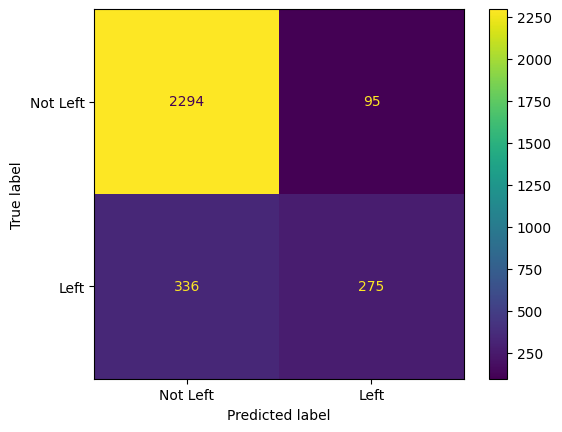

In [22]:
predictions_1 = clf_xgb_v1.predict(x_test)

# sns.set(font_scale=1)
cm = confusion_matrix(y_test, predictions_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [33]:
## Round 1
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter search space
param_distributions = {
    'max_depth': range(3, 10),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'gamma': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 20, 10),
    'scale_pos_weight': [1, 3, 5]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_distributions=param_distributions,
    n_iter=100,  # Adjust the number of iterations based on computational resources
    scoring='roc_auc',
    verbose=3,
    n_jobs=10,
    cv=5  # Increase the number of cross-validation folds
)

# Perform hyperparameter search
random_search.fit(x_train, y_train, early_stopping_rounds=10,eval_metric='auc',eval_set=[(x_test, y_test)], verbose=True)

# Print best hyperparameters and the corresponding ROC AUC score
print("Best Hyperparameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[0]	validation_0-auc:0.78668
[1]	validation_0-auc:0.84104
[2]	validation_0-auc:0.84680
[3]	validation_0-auc:0.85386
[4]	validation_0-auc:0.85556
[5]	validation_0-auc:0.85514
[6]	validation_0-auc:0.85639
[7]	validation_0-auc:0.85533
[8]	validation_0-auc:0.85393
[9]	validation_0-auc:0.85702
[10]	validation_0-auc:0.85990
[11]	validation_0-auc:0.85993
[12]	validation_0-auc:0.85972
[13]	validation_0-auc:0.85850
[14]	validation_0-auc:0.85995
[15]	validation_0-auc:0.86019
[16]	validation_0-auc:0.86058
[17]	validation_0-auc:0.86115
[18]	validation_0-auc:0.86101
[19]	validation_0-auc:0.86103
[20]	validation_0-auc:0.86185
[21]	validation_0-auc:0.86185
[22]	validation_0-auc:0.86165
[23]	validation_0-auc:0.86213
[24]	validation_0-auc:0.86215
[25]	validation_0-auc:0.86202
[26]	validation_0-auc:0.86183
[27]	validation_0-auc:0.86141
[28]	validation_0-auc:0.86165
[29]	validation_0-auc:0.86194
[30]	validation_0-auc:0.86188
[31]	validation_0

In [34]:
clf_xgb_v2 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=0.2222222222222222,
                               learning_rate=0.2,
                               max_depth=4,
                               reg_lambda=13.333333333333334,
                               scale_pos_weight=3,
                               subsample=0.9,
                               colsample_bytree=0.5)

clf_xgb_v2.fit(x_train,
               y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(x_test,y_test)])

[0]	validation_0-auc:0.78668
[1]	validation_0-auc:0.84104
[2]	validation_0-auc:0.84680
[3]	validation_0-auc:0.85386
[4]	validation_0-auc:0.85556
[5]	validation_0-auc:0.85514
[6]	validation_0-auc:0.85639
[7]	validation_0-auc:0.85533
[8]	validation_0-auc:0.85393
[9]	validation_0-auc:0.85702
[10]	validation_0-auc:0.85990
[11]	validation_0-auc:0.85993
[12]	validation_0-auc:0.85972
[13]	validation_0-auc:0.85850
[14]	validation_0-auc:0.85995
[15]	validation_0-auc:0.86019
[16]	validation_0-auc:0.86058
[17]	validation_0-auc:0.86115
[18]	validation_0-auc:0.86101
[19]	validation_0-auc:0.86103
[20]	validation_0-auc:0.86185
[21]	validation_0-auc:0.86185
[22]	validation_0-auc:0.86165
[23]	validation_0-auc:0.86213
[24]	validation_0-auc:0.86215
[25]	validation_0-auc:0.86202
[26]	validation_0-auc:0.86183
[27]	validation_0-auc:0.86141
[28]	validation_0-auc:0.86165
[29]	validation_0-auc:0.86194
[30]	validation_0-auc:0.86188
[31]	validation_0-auc:0.86225
[32]	validation_0-auc:0.86239
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2222222222222222, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

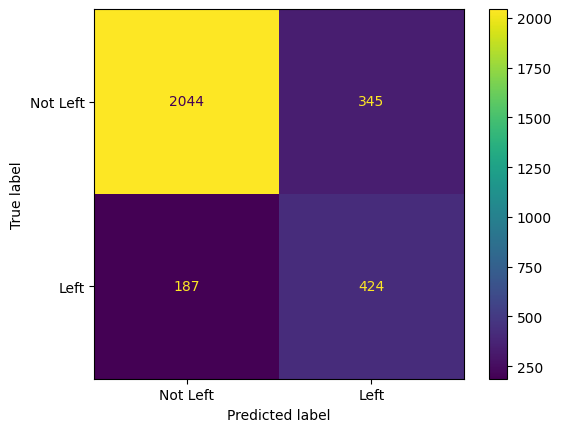

In [35]:
predictions_2 = clf_xgb_v2.predict(x_test)

cm = confusion_matrix(y_test, predictions_2, labels=clf_xgb_v2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

## **XGBoost Tree**
We can use the followig code to see the tree which was built in the model. Code will only create the first tree for visualization. You may need to scroll horizontally or vertically to see the whole tree.
You can also check the bias and gain for each variables.

weight:  {'age': 7.0, 'estimatedsalary': 3.0, 'numofproducts_1': 2.0, 'numofproducts_4': 1.0}
gain:  {'age': 211.62353515625, 'estimatedsalary': 9.045559883117676, 'numofproducts_1': 142.579833984375, 'numofproducts_4': 86.07135009765625}
cover:  {'age': 735.52001953125, 'estimatedsalary': 253.9140625, 'numofproducts_1': 1053.29296875, 'numofproducts_4': 651.9038696289062}
total_gain:  {'age': 1481.36474609375, 'estimatedsalary': 27.136680603027344, 'numofproducts_1': 285.15966796875, 'numofproducts_4': 86.07135009765625}
total_cover:  {'age': 5148.64013671875, 'estimatedsalary': 761.7421875, 'numofproducts_1': 2106.5859375, 'numofproducts_4': 651.9038696289062}


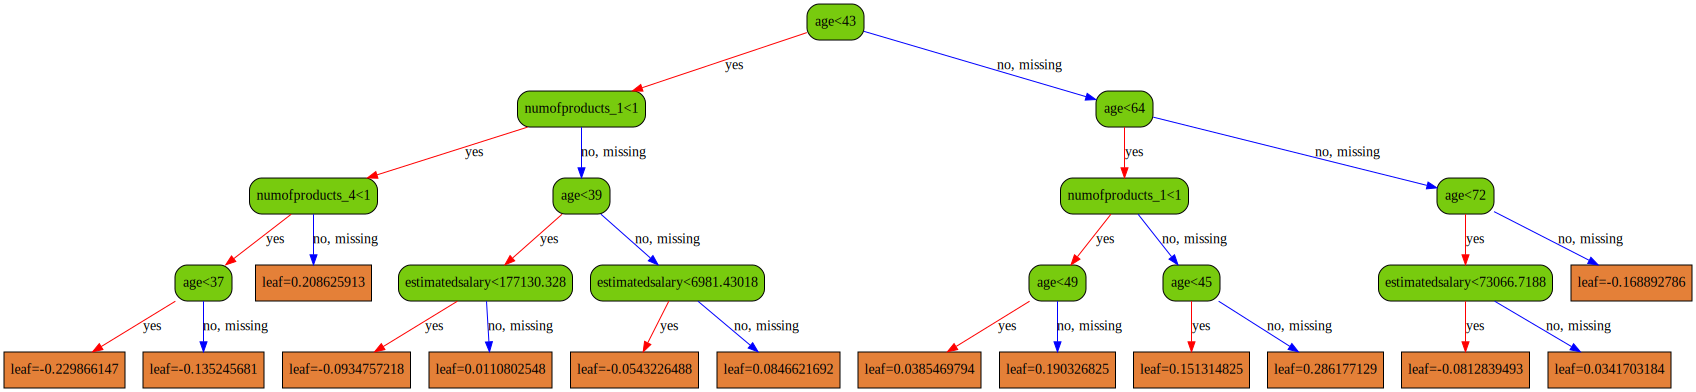

In [37]:
clf_xgb_v3 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=0.2222222222222222,
                               learning_rate=0.2,
                               max_depth=4,
                               reg_lambda=13.333333333333334,
                               scale_pos_weight=3,
                               subsample=0.9,
                               colsample_bytree=0.5,
                               n_estimators=1)

clf_xgb_v3.fit(x_train, y_train)

bst = clf_xgb_v3.get_booster()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb_v3, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

## **Feature Importance**
Generally, feature importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

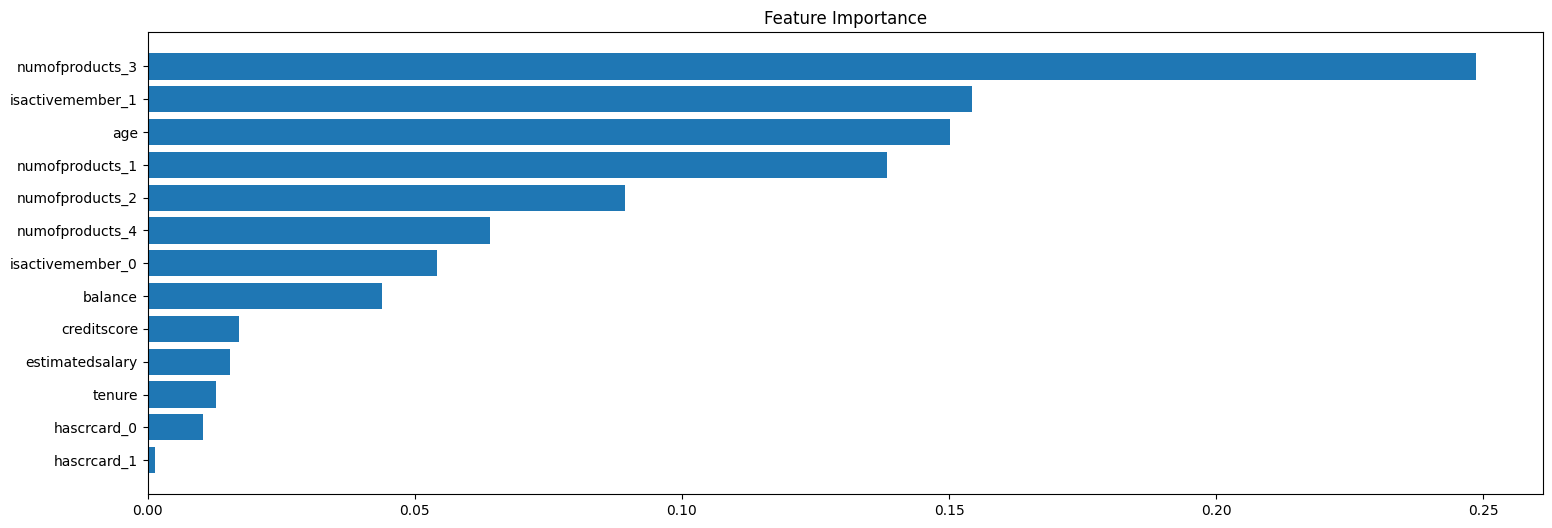

In [38]:
# Tree-based (or Gini) importance

feature_importance = clf_xgb_v2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

## **SHAP Importance**


SHAP importance offers important insight about the predictions created in experiments. It can help you understand which features are the most important to the prediction. SHAP importance is measured at row level.

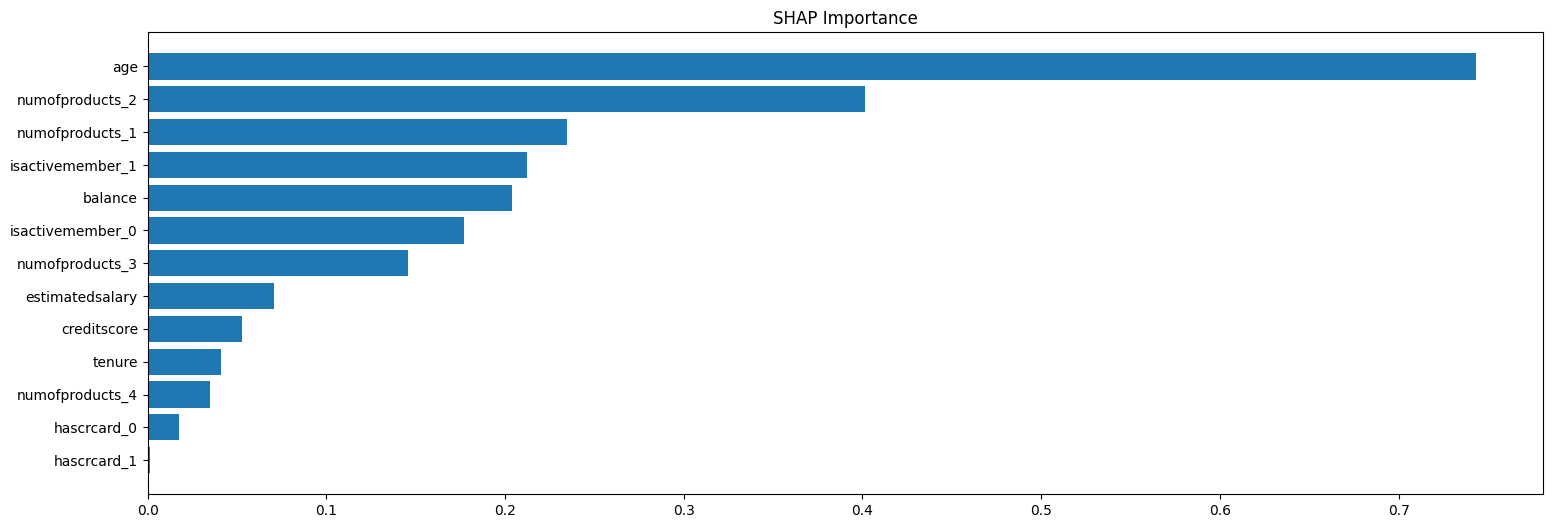

In [39]:
explainer = shap.Explainer(clf_xgb_v2)
shap_values = explainer(np.ascontiguousarray(x_test))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('SHAP Importance')
plt.show()

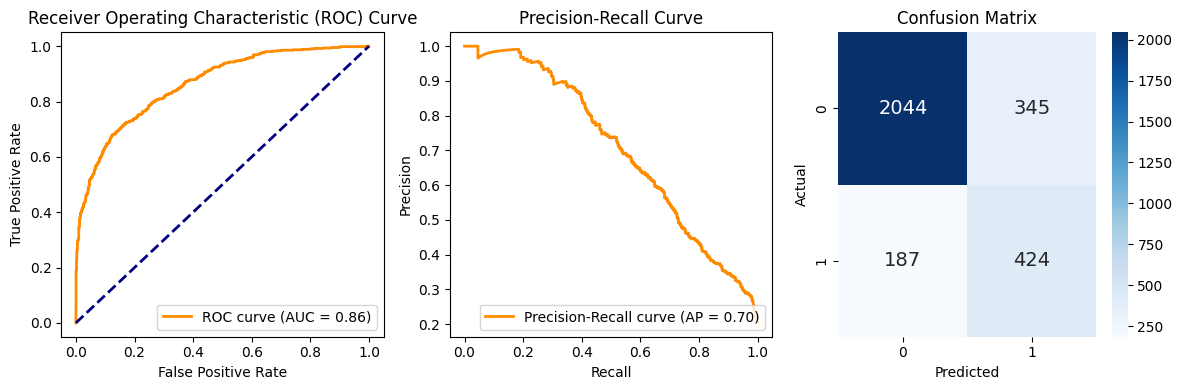

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report

def plot_evaluation_curves(model, X, y_true):
    # ROC-AUC Curve
    y_scores = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')

    # Confusion Matrix
    y_pred = model.predict(X)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # conf_matrix = confusion_matrix(y_valid, y_pred_valid)
    plt.subplot(1, 3, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 14})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Usage
plot_evaluation_curves(clf_xgb_v2, x_test, y_test)

In [41]:
import joblib
# Save the best model to a file
model_filename = 'best_xgb_model.joblib'
joblib.dump(clf_xgb_v2, model_filename)
print(f"Best model saved to {model_filename}")

Best model saved to best_xgb_model.joblib
